**Импорт данных:**

In [1]:
import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns

import numpy as np

import phik

import warnings
warnings.filterwarnings('ignore')

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import  ( 
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
    MinMaxScaler,
    RobustScaler
)
from sklearn.impute import SimpleImputer 
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.svm import SVR, SVC
from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder

# Задача 1: предсказание уровня удовлетворенности сотрудника

## Загрузка и предпросмотр данных

In [2]:
# функция для создания датафрейма
def read_data(f_name, separator, decimal='.'):

    try:
        data = pd.read_csv(f_name, sep=separator, decimal=decimal)
    except FileNotFoundError:
        data = pd.read_csv('datasets/' + f_name, sep=separator, decimal=decimal)

    return data

In [3]:
# считываем в датафрейм
satis_rate_train = read_data('train_job_satisfaction_rate.csv', ',')
satis_rate_test = read_data('test_features.csv', ',')
satis_rate_target = read_data('test_target_job_satisfaction_rate.csv', ',')

Взглянем на все таблицы по очереди:

In [4]:
# функция для ознакомления с таблицами
def observe_data(df):
    print('Превью таблицы (первые пять строк):\n')
    display(df.head())
    print('=' * 90)
    print('Информация о столбцах и типах данных:\n')
    df.info()
    print('=' * 90)
    print('Статистическая информация:\n')
    display(df.describe().T)

### Предпросмотр satis_rate_train

In [5]:
observe_data(satis_rate_train)

Превью таблицы (первые пять строк):



,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


Информация о столбцах и типах данных:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB
Статистическая информация:



,count,mean,std,min,25%,50%,75%,max
id,4000.0,544957.621000,257883.104622,100954.00,322836.75,534082.50,771446.00,999521.0
employment_years,4000.0,3.718500,2.542513,1.00,2.00,3.00,6.00,10.0
supervisor_evaluation,4000.0,3.476500,1.008812,1.00,3.00,4.00,4.00,5.0
salary,4000.0,33926.700000,14900.703838,12000.00,22800.00,30000.00,43200.00,98400.0
job_satisfaction_rate,4000.0,0.533995,0.225327,0.03,0.36,0.56,0.71,1.0


К названиям претензий нет. Типы данных корректны, видим несколько пропущенных строк в признаках `dept` и `level`. Чего-то необычного на первый взгляд по статистике не видим.

### Предпросмотр satis_rate_test

In [6]:
observe_data(satis_rate_test)

Превью таблицы (первые пять строк):



,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


Информация о столбцах и типах данных:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB
Статистическая информация:



,count,mean,std,min,25%,50%,75%,max
id,2000.0,552765.2135,253851.326129,100298.0,339052.0,550793.0,765763.75,999029.0
employment_years,2000.0,3.6665,2.537222,1.0,1.0,3.0,6.00,10.0
supervisor_evaluation,2000.0,3.5265,0.996892,1.0,3.0,4.0,4.00,5.0
salary,2000.0,34066.8000,15398.436729,12000.0,22800.0,30000.0,43200.00,96000.0


Названия столбцов в порядке. Типы данных тоже не имеют проблем, в тех же колонках есть пропуски - `dept` и `level`. В статистике нет чего-то аномального. Отношение тренировочных данных к тестовым - 2 к 1.

### Предпросмотр satis_rate_target

In [7]:
observe_data(satis_rate_target)

Превью таблицы (первые пять строк):



,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


Информация о столбцах и типах данных:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB
Статистическая информация:



,count,mean,std,min,25%,50%,75%,max
id,2000.0,552765.21350,253851.326129,100298.00,339052.00,550793.00,765763.75,999029.0
job_satisfaction_rate,2000.0,0.54878,0.220110,0.03,0.38,0.58,0.72,1.0


Название совпадает с таргетом тренировочного сета. Количество совпадает с необходимым для тестового. Тип данных верный. По статистике не видно аномалий.

**Вывод:**
Полученные данные представлены несколько таблицами отдельно для каждой задачи:

+ для первой задачи имеется таблица с тренировочными данными на 4000 записей и 9 признаков, включая целевой. Вторая и третья таблицы предназначены для теста и передставляют собой отдельно входные признаки и целевой. Из недостатков пропуски в столбцах `dept` и `level`.
+ Признаки можно разделить на количественные: 
    + `salary` и `job_satisfaction_rate`;
+ категориальные:
    + бинарные: `last_year_promo`, `last_year_violations`;
    + порядковые: `workload`, `employment_years`, `supervisor_evaluation`, `level`;
    + номинальные: `dept`.
+ для второй задачи имеем отдельно таблицу с тренировочными данными, для теста будет использована та же таблица, что и для первой задачи, и отдельно представлен целевой признак. Никаких недостатков не выявлено при первичном осмотре.

## Предобработка данных

### Датасет satis_rate_train

Вспомним, где находились наши пропуски.

In [8]:
satis_rate_train.isna().sum()

id                       0
dept                     6
level                    4
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64

In [9]:
satis_rate_train[satis_rate_train['dept'].isna()]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
1526,694746,NaN,junior,medium,5,no,no,4,21600,0.62
1630,814624,NaN,junior,medium,3,no,no,4,24000,0.88
1633,475114,NaN,junior,high,4,no,no,4,31200,0.63
2781,497243,NaN,junior,medium,1,no,no,3,26400,0.28
2975,168668,NaN,junior,low,3,no,no,4,18000,0.88
3866,641150,NaN,junior,low,3,no,yes,4,12000,0.54


In [10]:
satis_rate_train[satis_rate_train['level'].isna()]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
1209,631073,sales,NaN,medium,1,no,no,4,27600,0.66
1469,416327,sales,NaN,low,1,no,no,5,18000,0.73
1745,135043,sales,NaN,medium,1,no,no,3,26400,0.30
2522,998838,sales,NaN,medium,1,no,no,5,27600,0.71


Похоже, что это просто некоторая техническая ошибка или ошибка учета. Заполним эти строки на этапе подготовки модели в пайплайне.

Далее проверим на дубли.

In [11]:
satis_rate_train.drop('id', axis=1).duplicated().sum()

245

In [12]:
# проверка на число уникальных id и общего количества строк
len(satis_rate_train['id'].unique()) == satis_rate_train.shape[0]

True

Нашли 245 полных совпадений, невозможно сказать - это просто совпадения или ошибки при записи. Тем не менее т.к. все id у нас уникальные, оставим их без изменений.

In [13]:
for column in satis_rate_train.select_dtypes(include='object'):
    display(f'{column}:', satis_rate_train[column].unique())

'dept:'

array(['sales', 'hr', 'technology', 'purchasing', 'marketing', nan],
      dtype=object)

'level:'

array(['junior', 'middle', 'senior', nan], dtype=object)

'workload:'

array(['medium', 'high', 'low'], dtype=object)

'last_year_promo:'

array(['no', 'yes'], dtype=object)

'last_year_violations:'

array(['no', 'yes'], dtype=object)

Видим пропуски, остальное в порядке, исправим только опечатку:

In [14]:
satis_rate_train.loc[satis_rate_train['level'] == 'sinior', 'level'] = 'senior'

### Датасет satis_rate_test

Аналогично проверим на пропуски и в этой таблице:

In [15]:
satis_rate_test.isna().sum()

id                       0
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64

Есть пропуски в этих же столбцах, также оставим на заполнение в пайплайне.

Посмотрим, есть ли дубли:

In [16]:
satis_rate_test.drop('id', axis=1).duplicated().sum()

557

In [17]:
# проверка на число уникальных id и общего количества строк
len(satis_rate_test['id'].unique()) == satis_rate_test.shape[0]

True

Можно присоединить целевой признак и проверить, измениться ли с ним количество дублей. Целевой признак должен иметь одинаковые id сотрудников с таблицей satis_rate_test. Проверим это.

In [18]:
satis_rate_test['id'][~satis_rate_test['id'].isin(satis_rate_target['id'])].shape[0]

0

0 означает полное совпадение строк в столбце `id`. А значит все сотрудники и тут уникальные. Можно объединить таблицы.

In [19]:
# зададим id в качестве индексов, чтобы по ним соединять таблицы
satis_rate_test = satis_rate_test.set_index('id')
satis_rate_target = satis_rate_target.set_index('id')

# объединим таблицы в одну
satis_rate_test = satis_rate_test.join(satis_rate_target, how='inner')

In [20]:
satis_rate_test.duplicated().sum()

83

Осталось 83 строки, где совпадает даже уровень удовлетворенности сотрудника. Просмотрим категориальные данные:

In [21]:
for column in satis_rate_test.select_dtypes(include='object'):
    display(f'{column}:', satis_rate_test[column].unique())

'dept:'

array(['marketing', 'hr', 'sales', 'purchasing', 'technology', nan, ' '],
      dtype=object)

'level:'

array(['junior', 'middle', 'sinior', nan], dtype=object)

'workload:'

array(['medium', 'low', 'high', ' '], dtype=object)

'last_year_promo:'

array(['no', 'yes'], dtype=object)

'last_year_violations:'

array(['no', 'yes'], dtype=object)

Кроме пропусков, видим пробелы вместо категорий. Их тоже уберем позже. А сейчас исправим только опечатку.

In [22]:
satis_rate_test.loc[satis_rate_test['level'] == 'sinior', 'level'] = 'senior'

**Вывод:**

На данном этапе пропуски значений в категориальных столбцах `dept` и `level` решили заполнить на этапе подготовки модели. Включим в пайплайн соответсвующий инструмент для этого. 

Было обнаружены дубли в тренировочном сете - 245 строк, в тестовом - 83. Допускаем наличие полных совпадений среди сотрудников компании.

Также были найдены пробелы вместо названий в категориях у признаков `workload`, `level` в тестовом сете. Их тоже уберем на этапе моделирования.

## Исследовательский анализ данных

Т.к. категориальные и количественные данные имеют разные подходы в анализе, выделим в отдельные группы эти признаки:

In [23]:
quantity_cols = ['salary', 'job_satisfaction_rate']
category_cols = satis_rate_train.drop(quantity_cols, axis=1).drop('id', axis=1).columns

### Количественные данные

Построим гистограмму и боксплот для анализа количественных данных. Для оценки однородности построим тестовую и учебную выборку на одном графике.

In [24]:
def draw_plot(data1, data2, column):
    """Функция строит гистограмму разных
    выборок на одном графике и боксплот.
    На входе принимает столбцы выборок и название признака."""
    
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(13, 6))

    axs[0].hist(data1, bins=30, alpha=0.7, label='Train column')

    axs[0].hist(data2, bins=30, alpha=0.7, label='Test column')

    axs[0].set_title(f'Распределение признака {column}')
    axs[0].set_xlabel('Значение признака')
    axs[0].set_ylabel('Количество')
    axs[0].grid(True)
    axs[0].legend()


    data = [train, test]
    axs[1].boxplot(data, vert=True)
    plt.xticks([1, 2], ['Train column', 'Test column'])
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

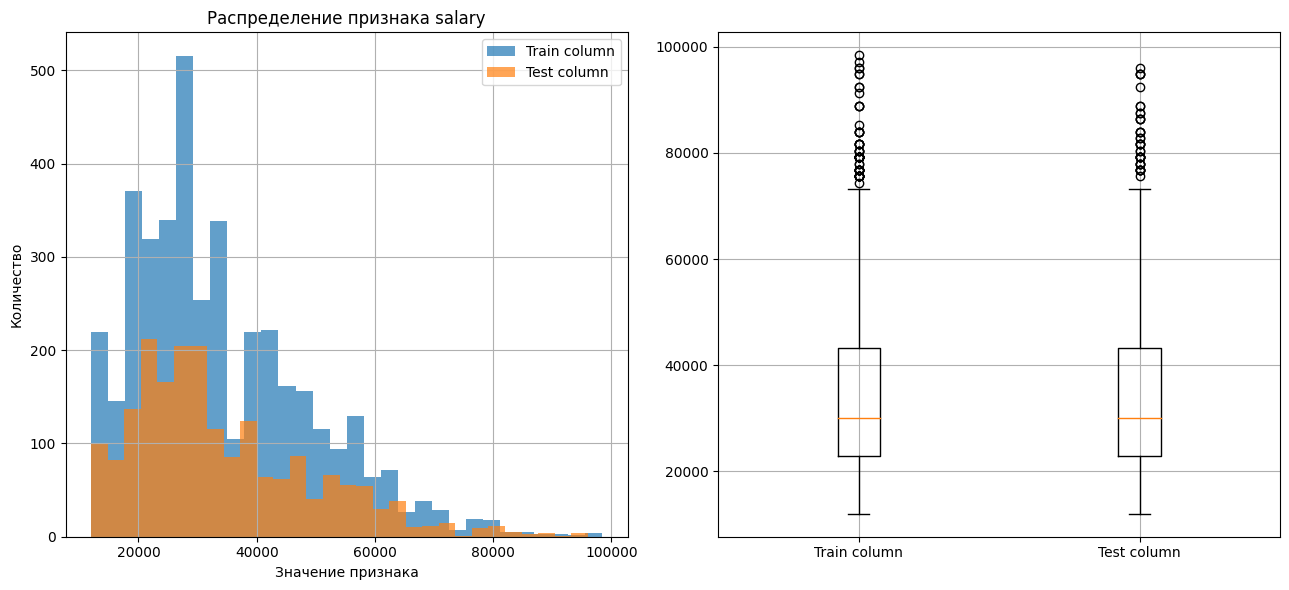

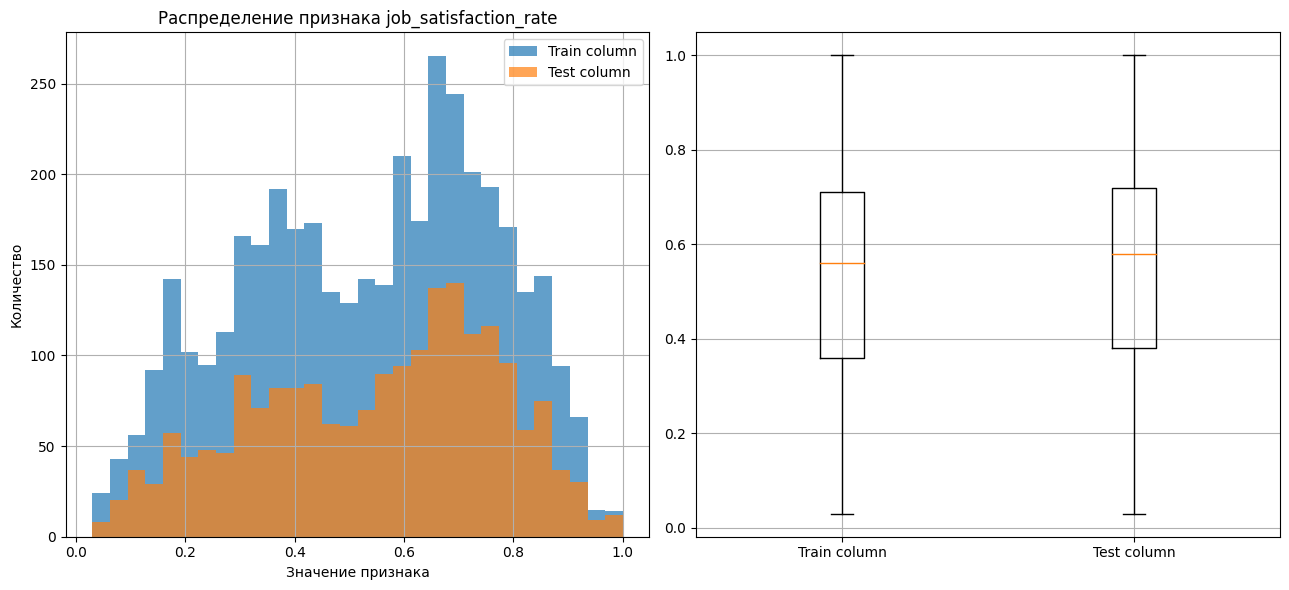

In [25]:
for column in quantity_cols:
    
    train = satis_rate_train[column]
    test = satis_rate_test[column]


    draw_plot(train, test, column)

In [26]:
satis_rate_train[quantity_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
salary,4000.0,33926.700000,14900.703838,12000.00,22800.00,30000.00,43200.00,98400.0
job_satisfaction_rate,4000.0,0.533995,0.225327,0.03,0.36,0.56,0.71,1.0


In [27]:
satis_rate_test[quantity_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
salary,2000.0,34066.80000,15398.436729,12000.00,22800.00,30000.00,43200.00,96000.0
job_satisfaction_rate,2000.0,0.54878,0.220110,0.03,0.38,0.58,0.72,1.0


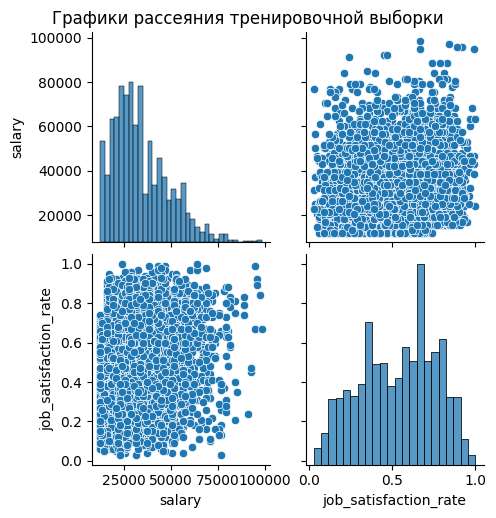

In [28]:
# строим графики рассеивания признаков с учетом категорий
sns.pairplot(satis_rate_train, vars=quantity_cols)
plt.suptitle(f'Графики рассеяния тренировочной выборки', y=1.02)
plt.show()

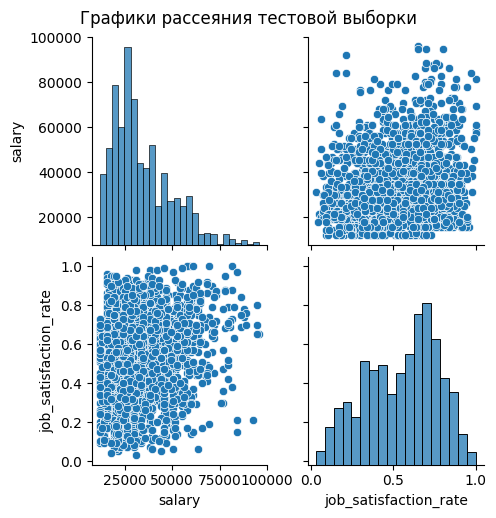

In [29]:
# строим графики рассеивания признаков с учетом категорий
sns.pairplot(satis_rate_test, vars=quantity_cols)
plt.suptitle(f'Графики рассеяния тестовой выборки', y=1.02)
plt.show()

Признак `salary` не имеет нормальное распределение, усечен левый хвост (объясняется наличием минимальной зарплаты) и имеет перекос. Также имеются выбросы.

Признак `job_satisfaction_rate` нормально распределен.

Данные из разных выборок однородны.

Признаки между собой не связаны линейно.

### Категориальные данные

Продолжим попарно сравнить тестовую и учебную выборки: для бинарных данных построим диаграмму, для номинальных и порядковых - столбчатую диаграмму.

In [30]:
def make_pie_plot(df, column):
    ''' Функция строит диаграмму. 
        На входе принимает датафрейм и название столбец с данными, 
        на которых надо построить график. '''
    
    labels = df[column].unique()
    sizes = df[column].value_counts()

    fig, ax = plt.subplots(figsize=(4, 4))
    ax.pie(sizes[labels], labels=labels, autopct='%1.1f%%',
           pctdistance=1.15, labeldistance=.3)
    ax.set_title(f'Соотношение в столбце {column}')
    
    plt.tight_layout()
    plt.show()

Диаграмма тренировочного сета:


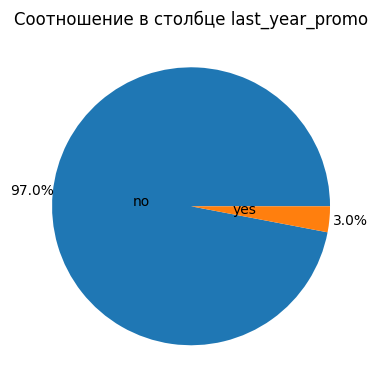

Диаграмма тестового сета:


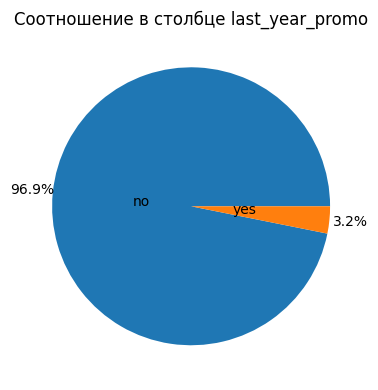

Диаграмма тренировочного сета:


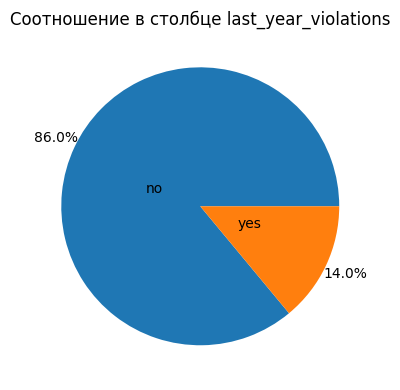

Диаграмма тестового сета:


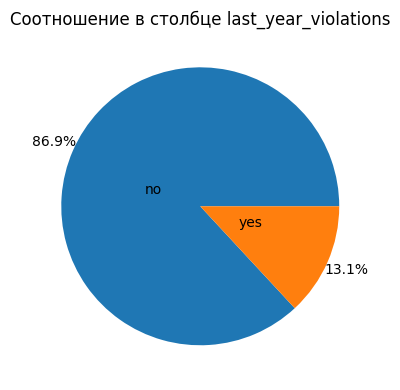

In [31]:
bin_cols = ['last_year_promo', 'last_year_violations']

for column in bin_cols:
    
    print('Диаграмма тренировочного сета:')
    make_pie_plot(satis_rate_train, column)
    print('Диаграмма тестового сета:')
    make_pie_plot(satis_rate_test, column)

Были повышены всего 3% сотрудников для тренировочного и 3.2% для тестового сетов. 14% и 13.1% соответственно нарушила трудовой договор.

In [32]:
def make_comparison_ordered(data1, data2, column):
    """Функция строит столбчатые диаграммы
    на одном графике.
    На входе принимает данные разных выборок и название столбца.
    """
    order = data1.index.sort_values()
    
    width = 0.3
    x = np.arange(len(order))
    
    fig, ax = plt.subplots()
    train_plot = ax.bar(x - width/2, data1, width, label='Train column')
    test_plot = ax.bar(x + width/2, data2, width, label='Test column')
    ax.set_title(f'Диаграмма распределения {column}')
    ax.set_xticks(x)
    ax.set_xticklabels(order)
    ax.set_xlabel('Категории')
    ax.set_ylabel('Количество')
    ax.grid(True)
    ax.legend()

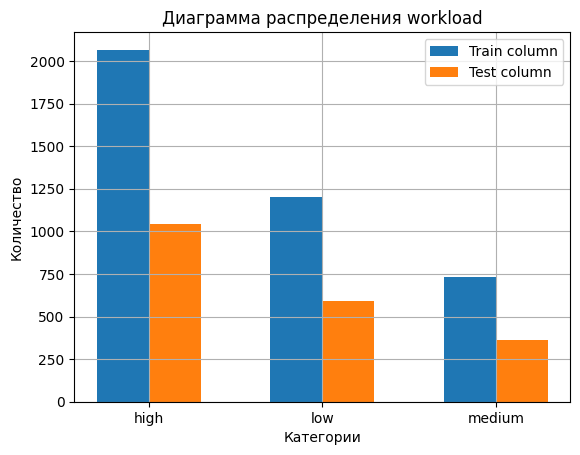

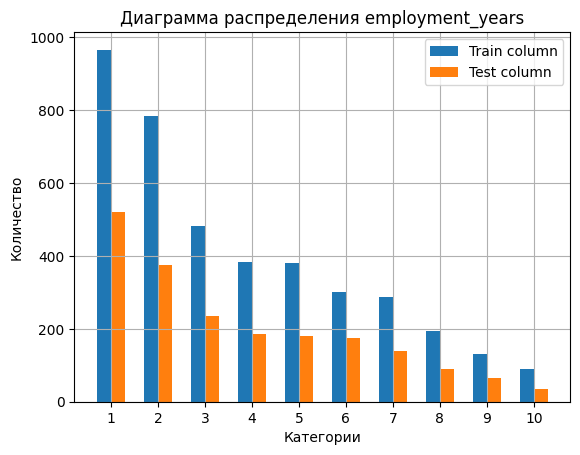

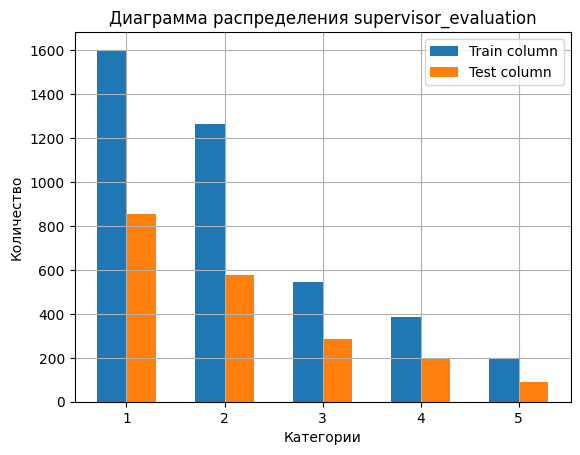

In [33]:
ordered_cols = ['workload', 'employment_years', 'supervisor_evaluation']
for column in ordered_cols:
    
    train = satis_rate_train[column].replace(' ', np.nan).dropna().value_counts()
    test = satis_rate_test[column].replace(' ', np.nan).dropna().value_counts()
    
    make_comparison_ordered(train, test, column)  

Данные однородны. Сотрудники в этой компании высоко нагружены, коллектив по большей части сотрудников, недавно работающих, руководство оценивает работу ниже среднего.

In [34]:
def make_comparison_nominal(data1, data2, column):
    """Функция строит столбчатые диаграммы
    на одном графике.
    На входе принимает данные разных выборок и название столбца.
    """
    order = data1.index.sort_values()
    
    width = 0.3
    y = np.arange(len(order))
    
    fig, ax = plt.subplots()
    train_plot = ax.barh(y - width/2, data1, width, label='Train column')
    test_plot = ax.barh(y + width/2, data2, width, label='Test column')
    ax.set_title(f'Диаграмма распределения {column}')
    ax.set_yticks(y)
    ax.set_yticklabels(order)
    ax.set_ylabel('Категории')
    ax.set_xlabel('Количество')
    ax.grid(True)
    ax.legend()

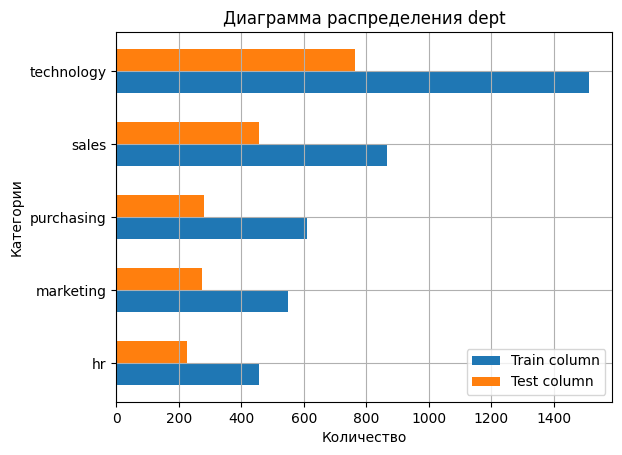

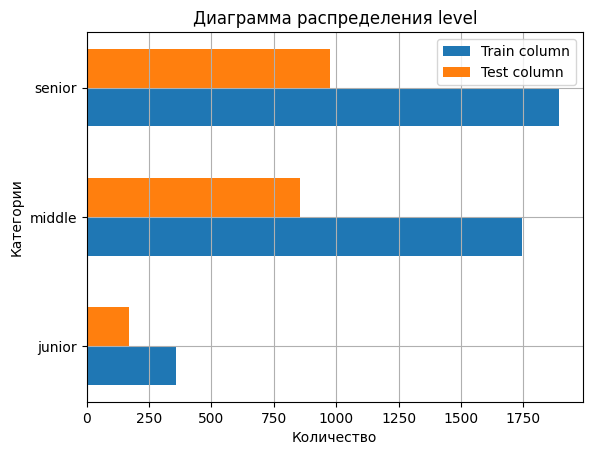

In [35]:
nominal_cols = ['dept', 'level']

for column in nominal_cols:
    
    train = satis_rate_train[column].replace(' ', np.nan).dropna().value_counts().sort_values()
    test = satis_rate_test[column].replace(' ', np.nan).dropna().value_counts().sort_values()
    
    make_comparison_nominal(train, test, column)

Соотношения выборок примерно одинаково. Больше всего специалистов наблюдаем в техническом и отделе продаж. Большая часть сотрудников уровня *senior* и *middle*.

### Корреляционный анализ

Для того, чтобы вычислить корреляцию и категориальных и количественных данных, используем подход Phik.

Вычислим коэффициенты корреляций для разных выборок:

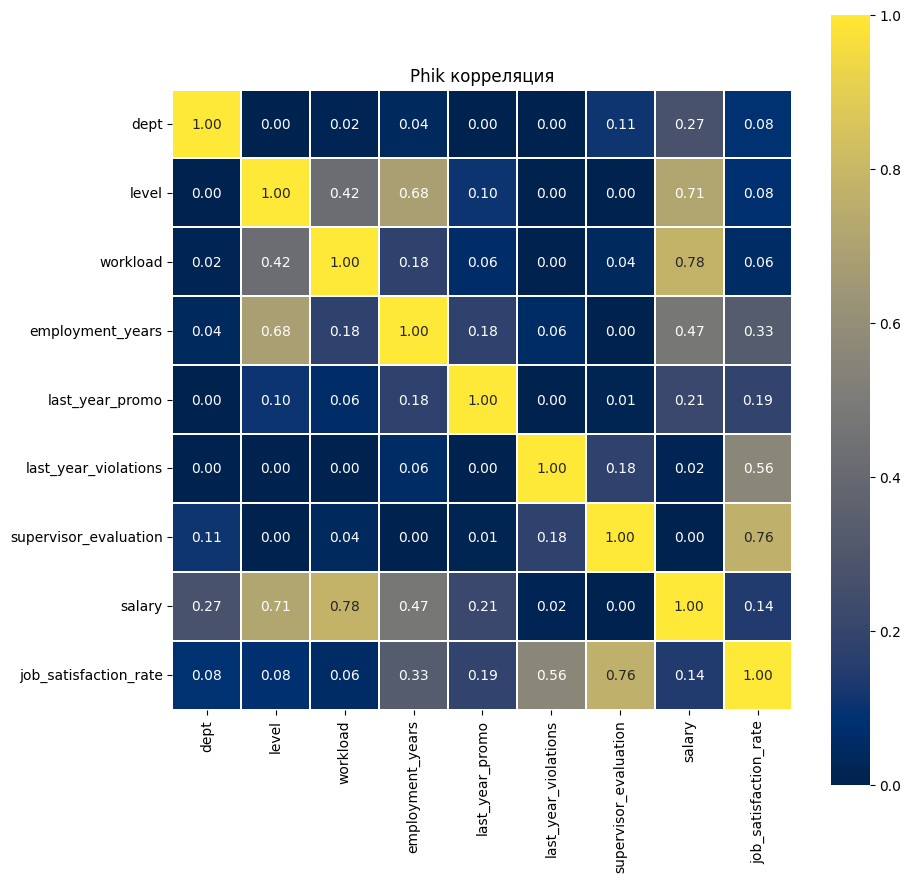

In [36]:
# визуализация коэффициентов корреляции
figsize = (10, 10)
fig = plt.subplots(figsize=figsize)
plt.title('Phik корреляция')
sns.heatmap(satis_rate_train
            .drop('id', axis=1)
            .phik_matrix(interval_cols=quantity_cols), 
            annot=True, cmap='cividis', 
            linewidth=0.1,
            fmt='.2f',
            square=True)
plt.show()

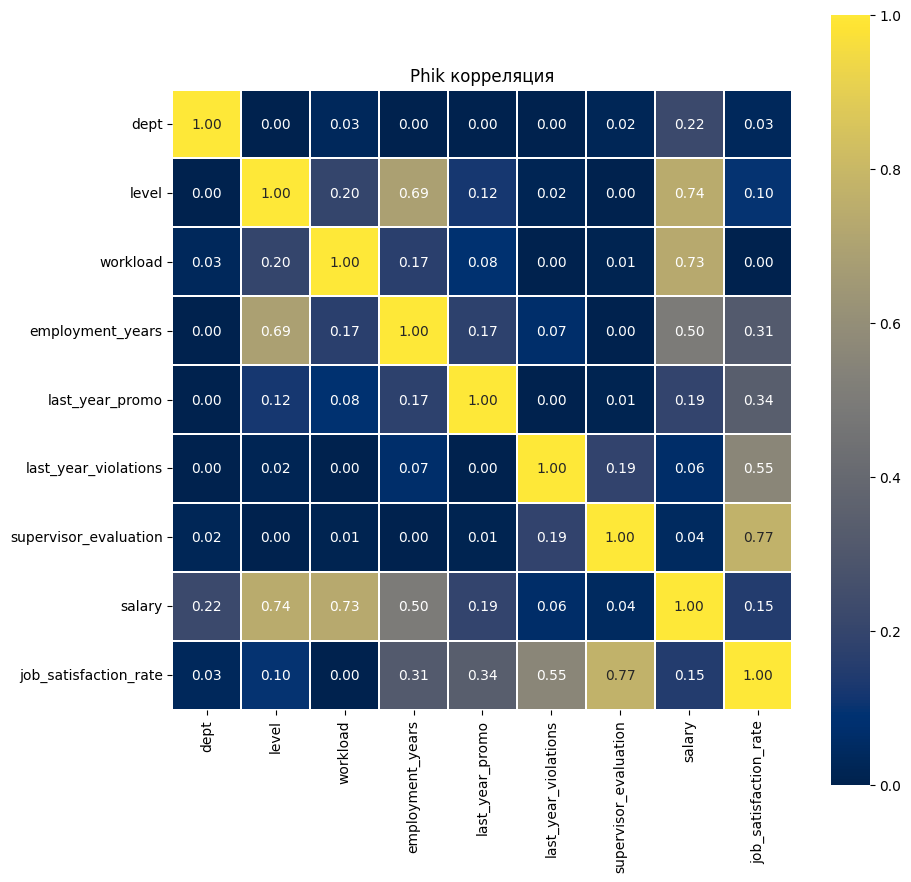

In [37]:
# визуализация коэффициентов корреляции
figsize = (10, 10)
fig = plt.subplots(figsize=figsize)
plt.title('Phik корреляция')
sns.heatmap(satis_rate_test
            .phik_matrix(interval_cols=quantity_cols), 
            annot=True, cmap='cividis', 
            linewidth=0.1,
            fmt='.2f',
            square=True)
plt.show()

Напомним, что целевым признаком является `job_satisfaction_rate`. С этим признаком наиболее сильно (0.76/0.77 - для тренировочной/тестовой выборки) коррелирует `supervisor_evaluation`, но недостаточно сильно, чтобы говорить о частичной мультиколлинеарности. В разных выборках коэффициенты имеют очень похожие величины.

**Вывод:**

Охарактеризуем данные перед моделированием:
Целевой признак `job_satisfaction_rate` - это количественный, непрерывный показатель,  не связан линейно с другим единственным количественным входным признаком - `salary`. Кроме этого, отметим, что признак `salary` имеет выбросы.

Корреляционный анализ не выявил сильной связи между всеми признаками, большинство не коррелирует или коррелирует от слабого до среднего уровня.

Тренировочная и тестовая выборки имеют высокую однородность.

Наличие порядковых и номинальных данных потребуют разные типы кодировщиков, при подготовке данных к моделированию. Не стоит забывать об устранении пропусков и пробелов в значениях.

## Построение модели

### Подготовка выборок

Выборки у нас были изначально разделены на тренировочную и тестовую, осталось только разделить целевой признак от входных:

In [38]:
RANDOM_STATE = 13

# разделяем данные на входные признаки и целевой
X_train = satis_rate_train.drop(['id', 'job_satisfaction_rate'], axis=1)
y_train = satis_rate_train['job_satisfaction_rate']

X_test = satis_rate_test.drop(['job_satisfaction_rate'], axis=1)
y_test = satis_rate_test['job_satisfaction_rate']

Разделим входные признаки по группам, для дальнейшей подготовки:

In [39]:
num_columns = ['salary']

ohe_columns = [
    'dept',
    'last_year_promo',
    'last_year_violations'
]

ord_columns = [
    'level',
    'workload',
    'employment_years',
    'supervisor_evaluation'
]

### Создание Pipeline

Для автоматизации используем пайплайн. Он будет состоять из нескольких этапов. Первый - это подготовка данных. Подготовим категориальные признаки: номинальные и бинарные. Не забудем, что в некоторых столбцах были пропуски, заменим их на моду.

In [40]:
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ohe',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe',
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
        )
    ]
)

Пайплайн для порядковых признаков:

In [41]:
ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',
            OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'senior'],
                    ['low', 'medium', 'high'],
                    [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10],
                    [1, 2, 3, 4, 5],
                ],
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
        (
            'simpleImputer_after_ord',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

Объединим эти пайпы и добавим кодер для количественных данных:

In [42]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)

К этапу подготовки данных добавим модель и обернем все это в финальный пайп:

In [43]:
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('model', DecisionTreeRegressor(random_state=RANDOM_STATE))
    ]
)

### Подбор модели

Теперь подберем модель. Предсказание уровня удовлетворённости сотрудника это задача линейной регрессии.Используем модели с различеым подходом решения этой задачи:
+ Классический подбор коэффициентов - LinearRegression;
+ Метод k-ближайших соседей - KNeighborsRegressor;
+ Метод опорных векторов - SVR;
+ Дерево решений - DecisionTreeRegressor.

In [44]:
param_grid = [
    {
        'model': [KNeighborsRegressor()],
        'preprocessor__num': [StandardScaler(), 
                              MinMaxScaler(), 
                              RobustScaler(), 
                              'passthrough'
                             ],
        'model__metric': ['euclidean', 'minkowski', 'cityblock'],
        'model__n_neighbors': range(1, 15),
        
    },
    
    {
        'model': [SVR()],
        'preprocessor__num': [
            StandardScaler(),
            MinMaxScaler(),
            RobustScaler(),
            'passthrough'
         ],
         'model__kernel': ['linear', 'rbf', 'sigmoid'], 
         'model__degree': [2, 3, 4, 5, 6],
         'model__gamma': ['scale', 'auto'],
         'model__C': [0.5, 1, 5, 10, 100]
    },
    
    {
        'model': [LinearRegression()],
        'preprocessor__num': [
            StandardScaler(),
            MinMaxScaler(),
            RobustScaler(),
            'passthrough'
        ],
    },
    
    {
        'model': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'preprocessor__num': [
            StandardScaler(),
            MinMaxScaler(),
            RobustScaler(),
            'passthrough'
        ],
        'model__max_depth': range(2, 20),
        'model__max_features': range(2, 20),
        'model__min_samples_split': range(2, 20)
    }
]

Модели и их гиперпараметры подготовили, теперь можно их перебрать, чтобы выявить лучшую. За метрику примем метрику SMAPE, которая измеряет ошибку как процентное отклонение между истинными значениями и предсказаниями. Реализуем ее:

In [45]:
def smape_metric(y_true, y_pred):
    return 100 * (np.abs(y_true - y_pred) / ((np.abs(y_true) + np.abs(y_pred)) / 2)).mean() 

scorer = make_scorer(smape_metric, greater_is_better=False)

Все у нас имеется, найдем лучшую модель:

In [46]:
search = RandomizedSearchCV(
    pipe_final,
    param_distributions=param_grid, 
    cv=5,
    scoring=scorer,
    n_jobs=-1,
    n_iter=50,
    random_state=RANDOM_STATE
)

search.fit(X_train, y_train)
print('Лучшая модель и её параметры:\n\n', search.best_estimator_)
print('Метрика SMAPE для лучшей модели:\n', search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_before_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                     

Лучшей моделью становится DecisionTreeRegressor, значение SMAPE на тренировочной выборке удовлетворяет условию. 

In [47]:
pd.set_option('display.max_colwidth', None)
result = pd.DataFrame(search.cv_results_).sort_values('rank_test_score')
result[['rank_test_score', 'param_model', 'mean_test_score','params']].head(10)

,rank_test_score,param_model,mean_test_score,params
18,1,DecisionTreeRegressor(random_state=13),-14.572957,"{'preprocessor__num': MinMaxScaler(), 'model__..."
46,2,DecisionTreeRegressor(random_state=13),-14.655338,"{'preprocessor__num': RobustScaler(), 'model__..."
20,3,DecisionTreeRegressor(random_state=13),-14.708894,"{'preprocessor__num': 'passthrough', 'model__m..."
3,4,DecisionTreeRegressor(random_state=13),-14.803624,"{'preprocessor__num': StandardScaler(), 'model..."
5,5,DecisionTreeRegressor(random_state=13),-14.846454,"{'preprocessor__num': StandardScaler(), 'model..."
28,6,DecisionTreeRegressor(random_state=13),-14.847208,"{'preprocessor__num': StandardScaler(), 'model..."
30,7,DecisionTreeRegressor(random_state=13),-14.850322,"{'preprocessor__num': RobustScaler(), 'model__..."
38,8,DecisionTreeRegressor(random_state=13),-14.859241,"{'preprocessor__num': MinMaxScaler(), 'model__..."
27,9,DecisionTreeRegressor(random_state=13),-14.865706,"{'preprocessor__num': StandardScaler(), 'model..."
34,10,DecisionTreeRegressor(random_state=13),-14.868994,"{'preprocessor__num': 'passthrough', 'model__m..."


Топ-10 моделей исключительно состоит из модели DecisionTreeRegressor, результаты всех моделей удовлетворяют условию.

### Проверка на тестовой выборке

Модель нашли, теперь проверим ее на тестовых данных:

In [48]:
best_model_reg = search
prediction_reg = best_model_reg.predict(X_test)

smape = smape_metric(y_test, prediction_reg)
print('SMAPE =', smape.round(4))

SMAPE = 13.9907


Метрика показывает, что модель удовлетворяет требованиям.

**Вывод:**

Из всех моделей наивысшего результата показала DecisionTreeRegressor. Со следующими гиперпараметрами :
+ max_depth=18, 
+ max_features=18,
+ min_samples_split=6.
Результат согласно метрике SMAPE: 14.57 на тренировочной и 13.90 на тестовой выборках.


Состав признаков - много категориальных, единственный количественный не имеет сильной линейной связи с целевым, что не позволило линейной регрессии эффективно рассчитать коэфициенты. По причине состава данных - категориальных больше чем количественных линейные модели и модель kNN уступают дереву решений. Поэтому такой результат можно считать закономерным.

# Задача 2: предсказание увольнения сотрудника из компании

## Загрузка данных

Загрузим оставшиеся таблицы для новой задачи:

In [49]:
quit_train = read_data('train_quit.csv', ',')
quit_target = read_data('test_target_quit.csv', ',')

Входными признаками тестовой выборки считаем те, с которыми мы уже работали на предыдущем этапе задания:

In [50]:
quit_test = satis_rate_test.copy()

### Предпросмотр quit_train

In [51]:
observe_data(quit_train)

Превью таблицы (первые пять строк):



,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


Информация о столбцах и типах данных:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB
Статистическая информация:



,count,mean,std,min,25%,50%,75%,max
id,4000.0,552099.28375,260158.031387,100222.0,327785.75,546673.0,781497.75,999915.0
employment_years,4000.0,3.70150,2.541852,1.0,2.00,3.0,6.00,10.0
supervisor_evaluation,4000.0,3.47475,1.004049,1.0,3.00,4.0,4.00,5.0
salary,4000.0,33805.80000,15152.415163,12000.0,22800.00,30000.0,43200.00,96000.0


Названия столбцов соответствуют стандарту. По типам данных вопросов нет, пропусков нет. По статистике ничего аномального.

### Предпросмотр quit_target

In [52]:
observe_data(quit_target)

Превью таблицы (первые пять строк):



,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


Информация о столбцах и типах данных:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB
Статистическая информация:



,count,mean,std,min,25%,50%,75%,max
id,2000.0,552765.2135,253851.326129,100298.0,339052.0,550793.0,765763.75,999029.0


Никаких нареканий таблица с целевым признаком не вызывает.

**Вывод:**

Набор признаков отличается от датасетов, с которыми мы уже поработали, признаком `quit`, который обозначает увольнение сотрудника из компании. Он же и является целевым. Однако, в тренировочной выборке отсутствует признак `job_satisfaction_rate`. Необходимость его наличия проверим в исследовательском анализе. В целом данные более высоко качества, не содержат пропусков и явных ошибок.

## Предобработка данных

In [53]:
quit_train.drop('id', axis=1).duplicated().sum()

1413

Дублей достаточно большое количество. 

In [54]:
for column in quit_train.select_dtypes(include='object'):
    display(f'{column}:', quit_train[column].unique())

'dept:'

array(['sales', 'purchasing', 'marketing', 'technology', 'hr'],
      dtype=object)

'level:'

array(['middle', 'junior', 'sinior'], dtype=object)

'workload:'

array(['high', 'medium', 'low'], dtype=object)

'last_year_promo:'

array(['no', 'yes'], dtype=object)

'last_year_violations:'

array(['no', 'yes'], dtype=object)

'quit:'

array(['no', 'yes'], dtype=object)

С названиями категорий все в порядке.

In [55]:
quit_train.loc[quit_train['level'] == 'sinior', 'level'] = 'senior'

Теперь проверим целевой признак тестовой выборки:

In [56]:
quit_target['quit'].unique()

array(['yes', 'no'], dtype=object)

Проблем здесь нет.

**Вывод:** В тренировочной выборке выявили свыше 30% строк, полностью одинаковых. С одной стороны все сотрудники уникальны и дублей быть не должно, с другой, это может быть ошибки при заполнении данных.

## Исследовательский анализ данных

### Количественные данные

Посмотрим на гистограмму количественных признаков.

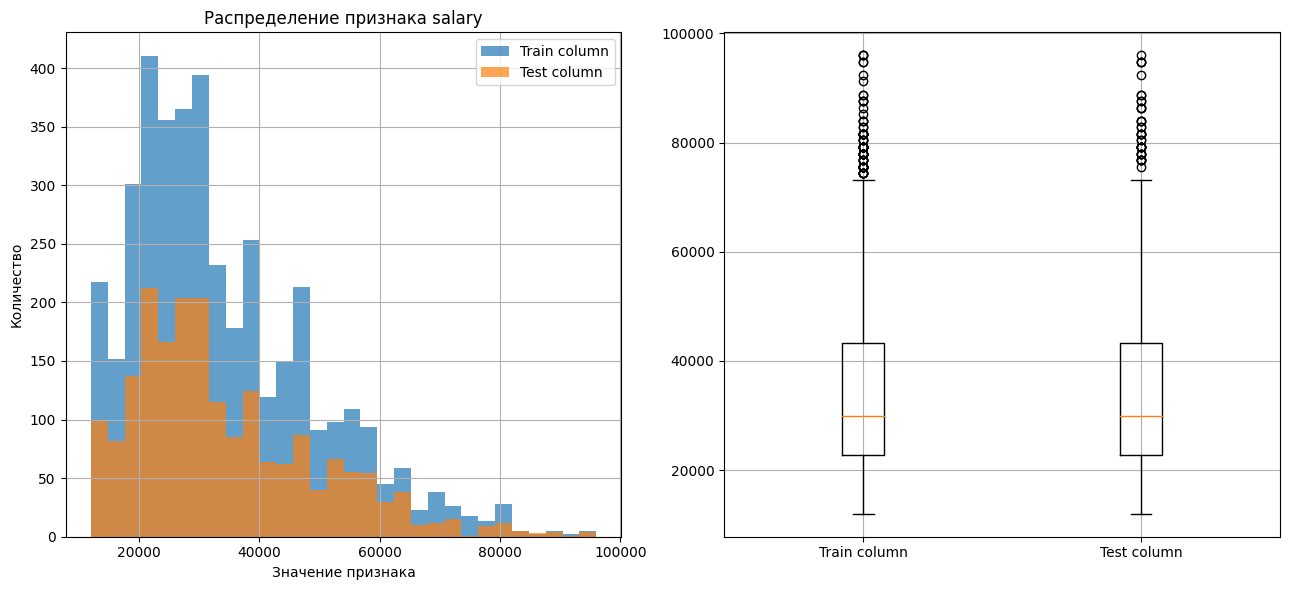

In [57]:
train = quit_train['salary']
test = quit_test['salary']

draw_plot(train, test, 'salary')

Данные по зарплате не распределены нормально, есть выбросы в обеих выборках. Отметим однородность значений в выборках.

### Категориальные данные

In [58]:
quit_target['quit'].value_counts()

quit
no     1436
yes     564
Name: count, dtype: int64

In [59]:
quit_train['quit'].value_counts()

quit
no     2872
yes    1128
Name: count, dtype: int64

Целевой признак дисбалансирован в сторону значения *нет*. В 2.5 раза уволившихся сотрудников меньше для тестовой выборки и тренировочной.

Воспользуемся подходами для просмотра соотношений категории из предыдущего анализа:

Диаграмма тренировочного сета:


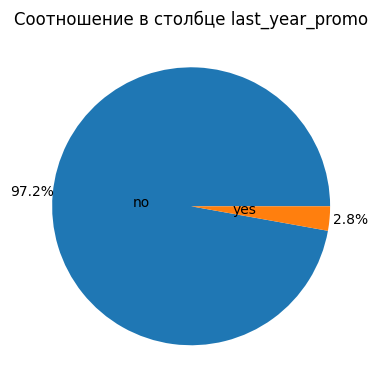

Диаграмма тестового сета:


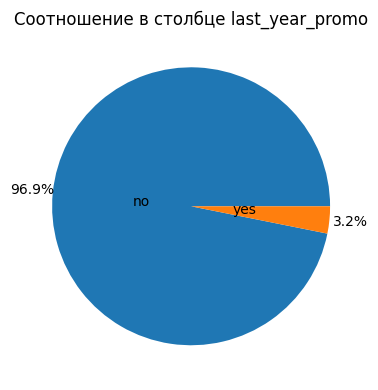

Диаграмма тренировочного сета:


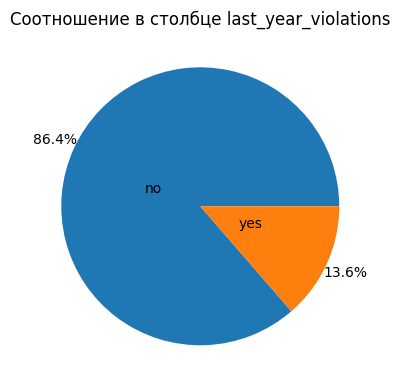

Диаграмма тестового сета:


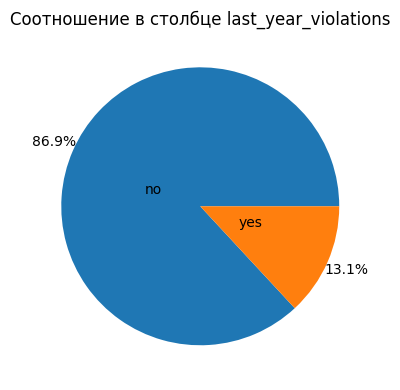

In [60]:
for column in bin_cols:
    
    print('Диаграмма тренировочного сета:')
    make_pie_plot(quit_train, column)
    print('Диаграмма тестового сета:')
    make_pie_plot(quit_test, column)

Бинарные данные однородны, значения похожи на предыдущие датасеты.

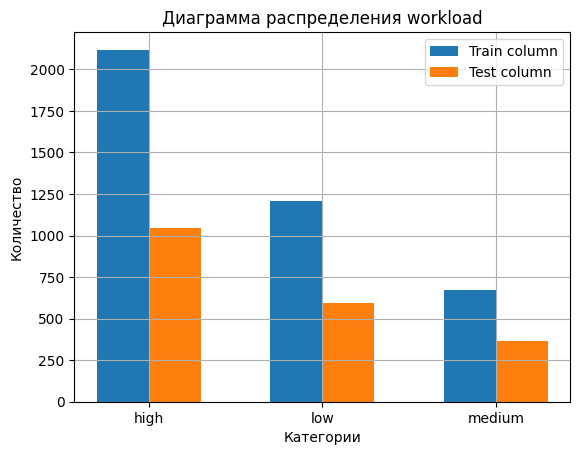

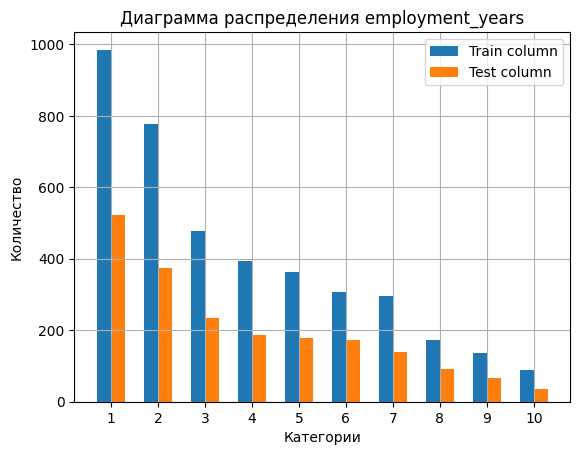

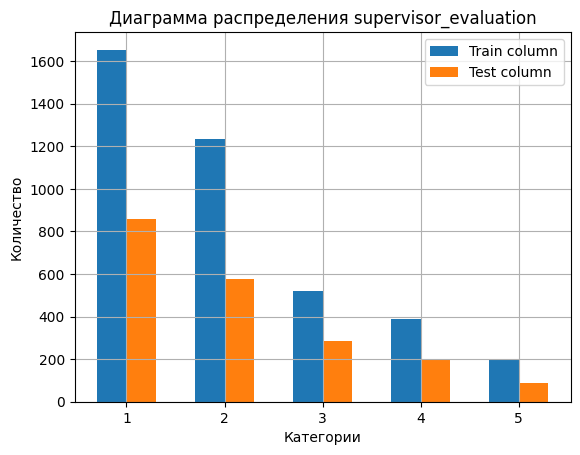

In [61]:
ordered_cols = ['workload', 'employment_years', 'supervisor_evaluation']
for column in ordered_cols:
    
    train = quit_train[column].value_counts()
    test = quit_test[column].replace(' ', np.nan).dropna().value_counts()
    
    make_comparison_ordered(train, test, column)  

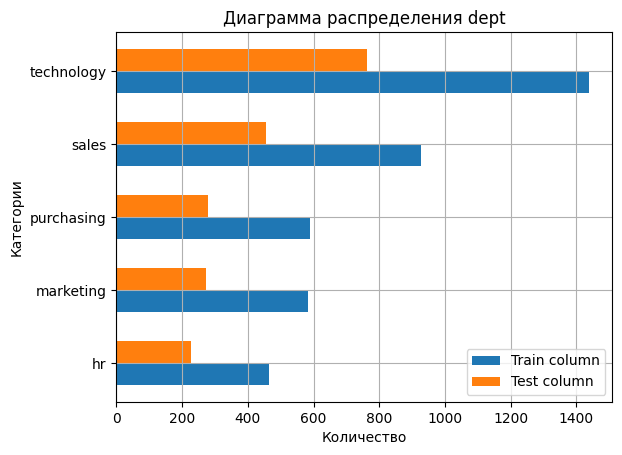

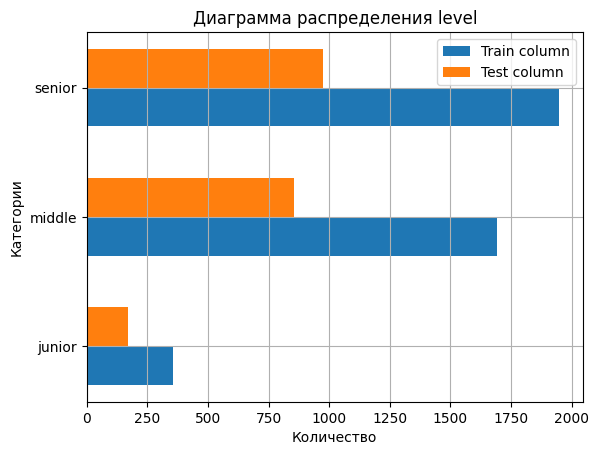

In [62]:
nominal_cols = ['dept', 'level']

for column in nominal_cols:
    
    train = quit_train[column].value_counts().sort_values()
    test = quit_test[column].replace(' ', np.nan).dropna().value_counts().sort_values()
    
    make_comparison_nominal(train, test, column)

Остальные категориальные признаки однородны, между тренировочной и тестовой выборками, так и между первыми датасетами.

Целевой признак: `quit` - категориальный, посмотрим в разрезе этого признака на входные. Т.к. тренировочные и тестовые выборки достаточно однородны, посмотрим только на тренировочном датасете.

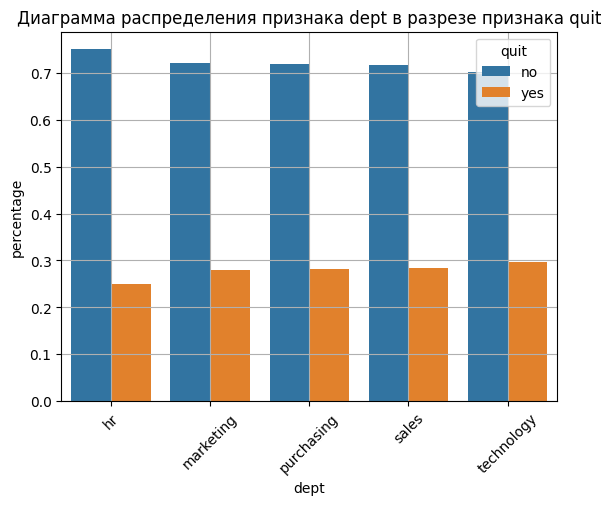

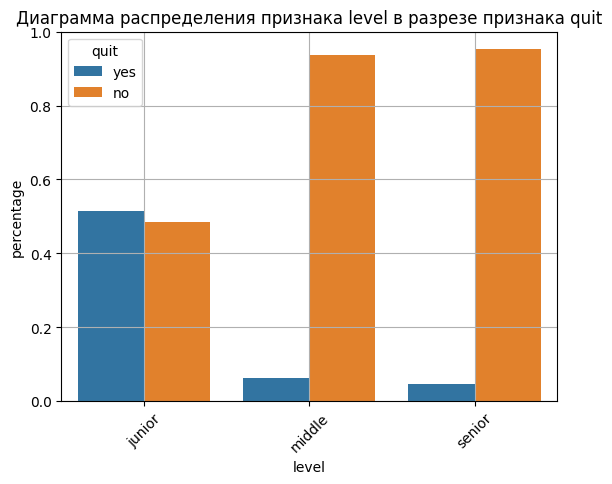

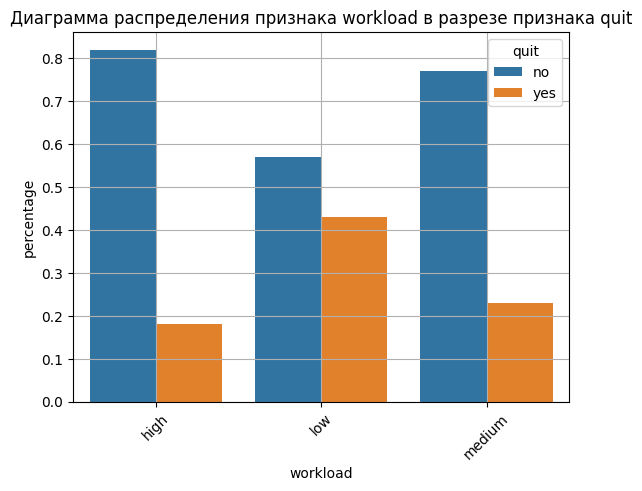

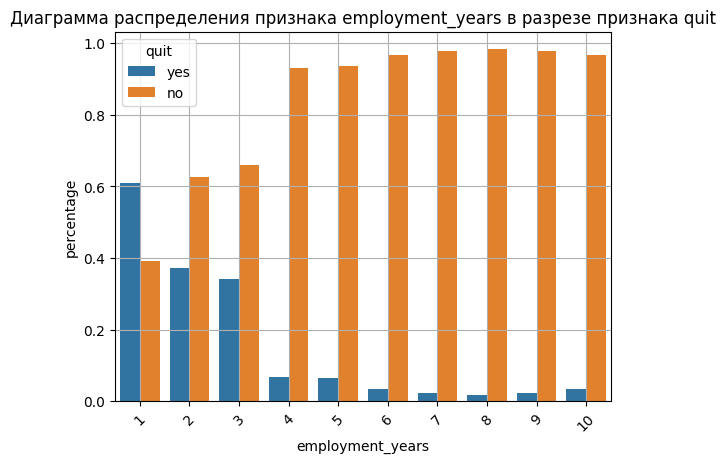

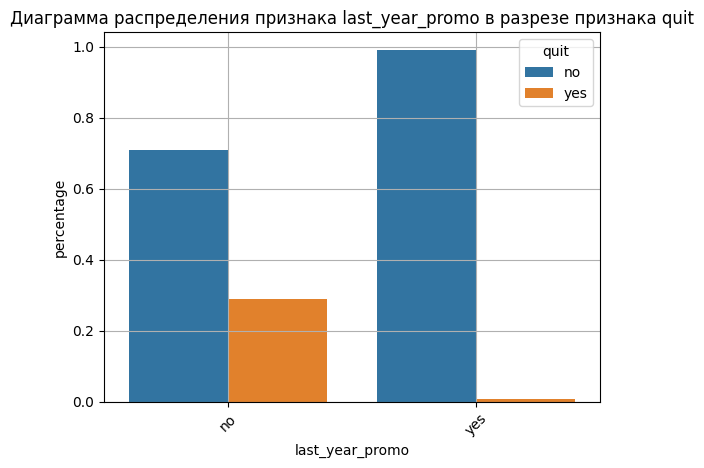

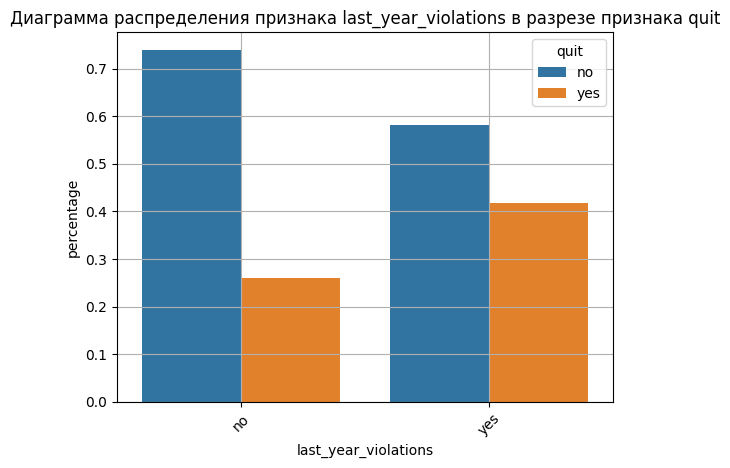

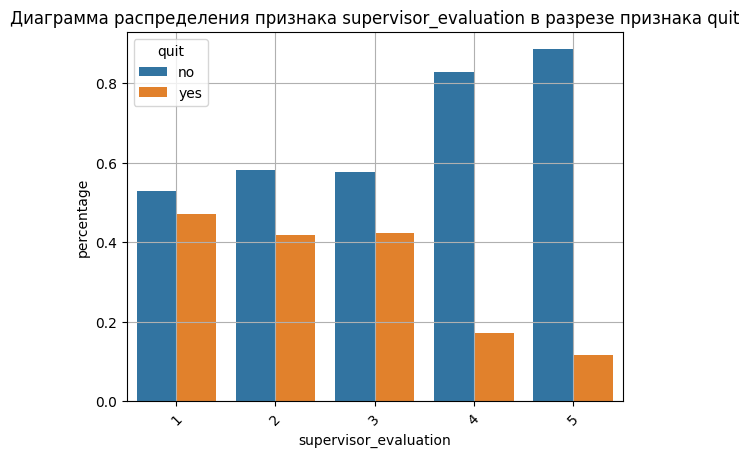

In [63]:
for column in quit_train.drop(['id', 'quit', 'salary'], axis=1).columns:
    
    data = quit_train.groupby([column])['quit'].value_counts(normalize=True).reset_index(name='percentage')
    sns.barplot(data=data, x=column, y='percentage', hue='quit')
    plt.title(f'Диаграмма распределения признака {column} в разрезе признака quit')
    plt.xticks(rotation=45)
    plt.grid()
    plt.show()

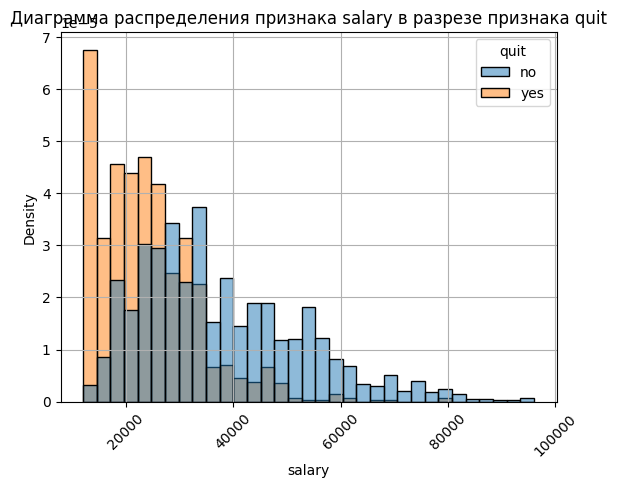

In [64]:
sns.histplot(data=quit_train, x='salary', hue='quit', stat='density', common_norm=False)
plt.title(f'Диаграмма распределения признака salary в разрезе признака quit')
plt.xticks(rotation=45)
plt.grid()
plt.show()

In [65]:
# средняя зарплата среди уволившихся
round(quit_train.loc[quit_train['quit'] == 'yes']['salary'].mean(), 2)

23885.11

+ Примерно в одинаковой пропорции распределено число увольняющихся сотрудников по отделам - от 25 до 29% от работающих в отделе сотрудников. Лидирует технический отдел. 
+ Тенденция на увольнение сосредоточена среди сотрудников уровня junior (свыше 50%).
+ Среди слабозагруженных наблюдается наибольшее число увольнений(около 43%) в отличие от средненагруженных(23%) и высоконагруженных сотрудников(18%).
+ Большая часть увольнений приходится на сотрудников, проработавших менее 4 лет:
    + 61% среди проработавших 1 год;
    + 37% - 2 года;
    + 34% - 3 года.
+ Почти все сотрудники, которые уволились, не получили повышение(29% от общего числа, кто не был повышен).
+ Сотрудники, нарушившие дисциплину, чаще увольняются(42%) чем ненарушившие(26%).
+ Высокий процент (40-50%) уволившихся среди сотрудников, оцененных руководством ниже 4 баллов:
    + 47% среди оцененных в 1 балл;
    + 42% - 2 балла;
    + 42% - 3 балла.
+ Основная часть сотрудников, покидающая компанию, получает до 35 тысяч (средняя - 23885).

### Исследование признака job_satisfaction_rate

Из имеющихся признаков мы еще не оценивали признак `job_satisfaction_rate`, который имелся в первых датасетах. По своему смыслу он должен сильно влиять на решения сотрудника уволиться. Посмотреть на него мы имеем возможность только в тетовом сете. Для этого присоединим целевой признак к таблице.

In [66]:
quit_test.index[~quit_test.index.isin(quit_target['id'])].shape[0]

0

In [67]:
# зададим id в качестве индексов, чтобы по ним соединять таблицы
quit_target = quit_target.set_index('id')

# объединим таблицы в одну
quit_test = quit_test.join(quit_target, how='inner')

In [68]:
quit_test.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate,quit
id,,,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800,0.79,no
686555,hr,junior,medium,1,no,no,4,30000,0.72,no
467458,sales,middle,low,5,no,no,4,19200,0.64,no
418655,sales,middle,low,6,no,no,4,19200,0.60,no
789145,hr,middle,medium,5,no,no,5,40800,0.75,no


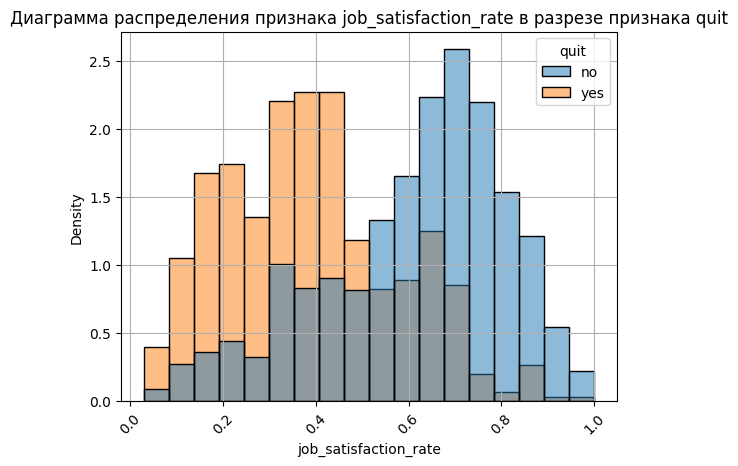

In [69]:
sns.histplot(data=quit_test, x='job_satisfaction_rate', hue='quit', stat='density', common_norm=False)
plt.title(f'Диаграмма распределения признака job_satisfaction_rate в разрезе признака quit')
plt.xticks(rotation=45)
plt.grid()
plt.show()

Видим, что данный признак нормально распределен, но имеет три выраженных локальных пика. Рассмотрение признака в разрезе целевого дает понять, что пики совпадают с распределением решений уволиться: сотрудники, считающие, что их удовлетворение от работы менее 50%,  имеют высокую вероятность уволиться. Удовлетворенность работой находиться на уровне 35-40% - вероятносять около 50%, ниже - вероятность возрастает вплоть до 75%. 
Действительно, данный входной признак позволит сделать прогноз более точным.

Тогда подготовим тренировочную выборку, добавив этот признак, который можно получить путем прогноза имеющихся данных.

In [70]:
job_satisfaction_rate_train = best_model_reg.predict(quit_train.drop(['id', 'quit'], axis=1))
job_satisfaction_rate_test = best_model_reg.predict(quit_test.drop(['quit', 'job_satisfaction_rate'], axis=1))

quit_train['job_satisfaction_rate_pred'] = job_satisfaction_rate_train
quit_test['job_satisfaction_rate_pred'] = job_satisfaction_rate_test

In [71]:
quit_train.head(2)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate_pred
0,723290,sales,middle,high,2,no,no,4,54000,no,0.618000
1,814010,sales,junior,medium,2,no,no,4,27600,no,0.826111


In [72]:
quit_test.head(2)

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate,quit,job_satisfaction_rate_pred
id,,,,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800,0.79,no,0.872000
686555,hr,junior,medium,1,no,no,4,30000,0.72,no,0.681429


Теперь тренировочная выборка имеет еще один входной признак.

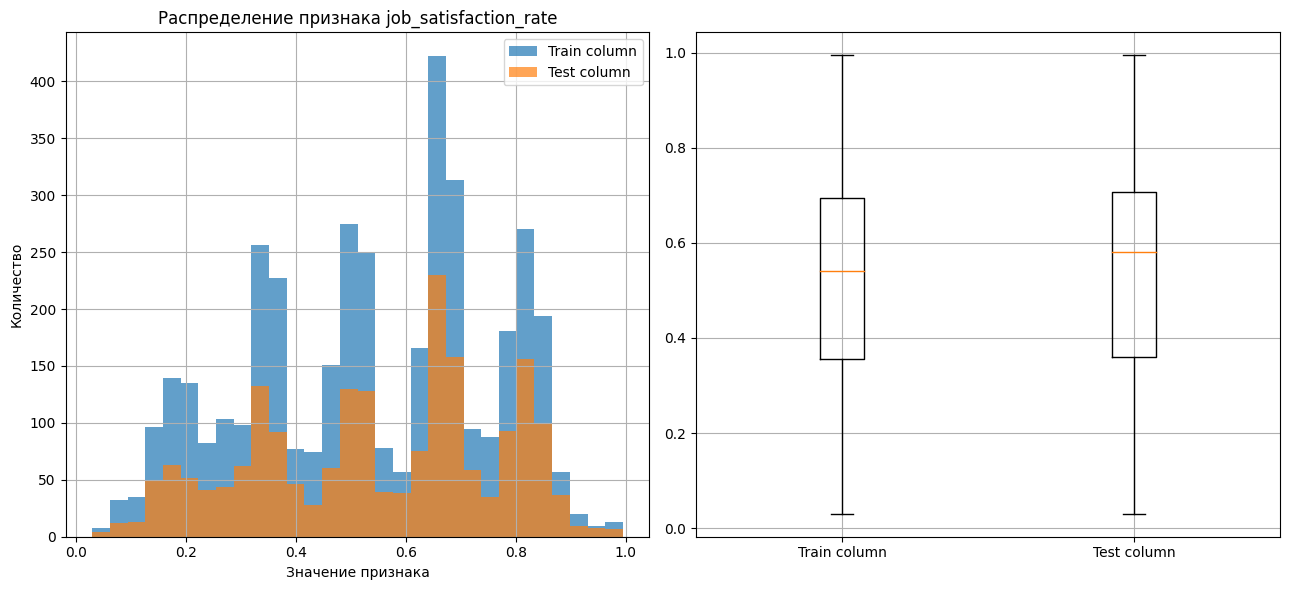

In [73]:
train = quit_train['job_satisfaction_rate_pred']
test = quit_test['job_satisfaction_rate_pred']

draw_plot(train, test, 'job_satisfaction_rate')

Видим, что модель определила локальные пики, которые мы видели на тестовой выборке. Предсказанные значения образуют более выраженные пики.

### Корреляционный анализ

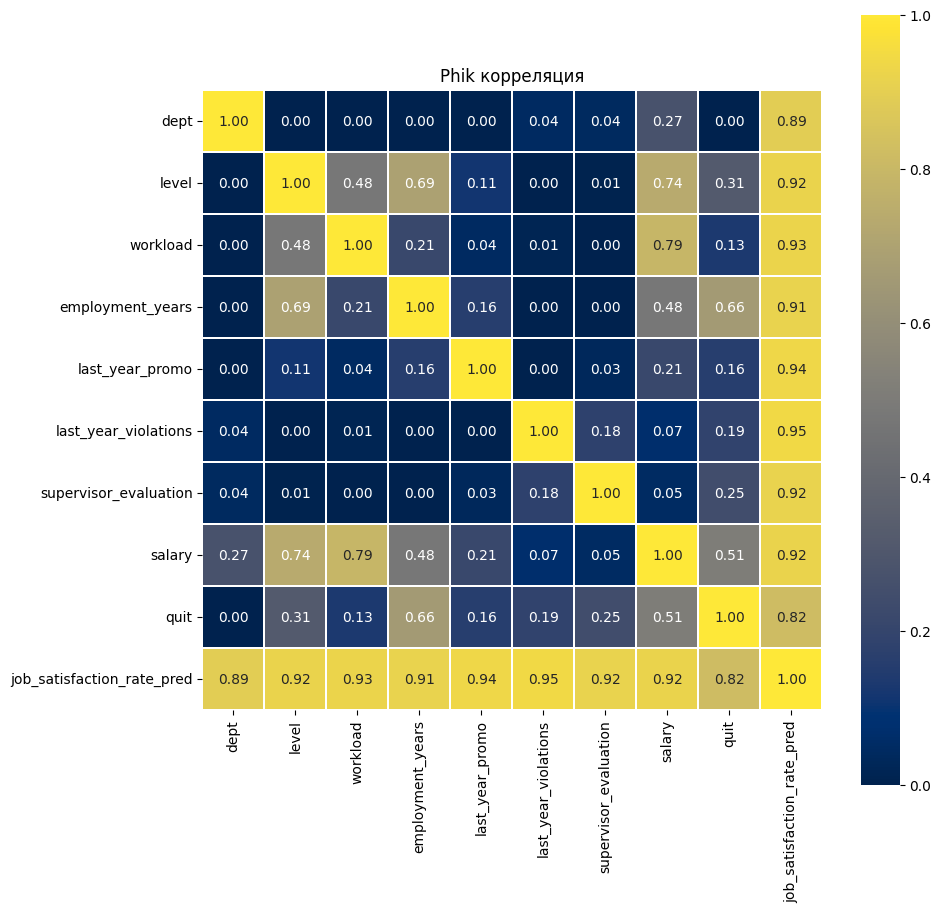

In [74]:
# визуализация коэффициентов корреляции
figsize = (10, 10)
fig = plt.subplots(figsize=figsize)
plt.title('Phik корреляция')
sns.heatmap(quit_train
            .drop('id', axis=1)
            .phik_matrix(interval_cols=['salary', 'job_satisfaction_rate']), 
            annot=True, cmap='cividis', 
            linewidth=0.1,
            fmt='.2f',
            square=True)
plt.show()

У целевого признака нет сильной связи с любым из входных признаков. Самое высокое значение корреляции с целевым наблюдается у признаков `employment_years`(0.66), `salary`(0.56) и `job_satisfaction_rate`(0.52), остальные имеют низкую связь или не имеют. По этой причине можно не включать признак `dept` с нулевым коэффициентом.

**Вывод:**

Исследовательский анализ показал, что тренировочные и тестовые выборки однородны, как между собой, так и между текущими данными и данными, которые мы использовали в задаче рагрессии.

Доказали, что имеется взаимосвязь между удовлетворением от работы и желанием уволиться. Поэтому добавили в тренировочную выборку новый признак, сгенерированный моделью, которую мы подбирали в предыдущей задаче.

Целевой признак `quit` - категориальный бинарный, имеет дисбаланс. Посмотрев на данные в разрезе этого признака можно сформировать наиболее вероятное признаковое описание, людей, которые хотят уволиться:
+ сотрудники уровня junior;
+ слабая загруженность на рабочем месте;
+ проработал менее 4 лет в компании;
+ не получил повышение в прошлом году;
+ имеет низкую оценку со стороны руководства;
+ сумма заработной платы не превышает 35 тыс.

Корреляционный анализ не выявил сильной корреляции между признаками.

## Построение модели

### Подготовка выборок

Снова подготовим выборки:

In [75]:
RANDOM_STATE = 13

# разделяем данные на входные признаки и целевой
X_train = quit_train.drop(['id', 'quit', 'dept'], axis=1)
y_train = quit_train['quit']

X_test = quit_test.drop(['quit', 'dept', 'job_satisfaction_rate'], axis=1)
y_test = quit_test['quit']

In [76]:
print('Соотношение категорий в тренировочной выборке:',
     y_train.value_counts()[0] / y_train.value_counts()[1])
print('Соотношение категорий в тестовой выборке:',
     y_test.value_counts()[0] / y_test.value_counts()[1])

Соотношение категорий в тренировочной выборке: 2.5460992907801416
Соотношение категорий в тестовой выборке: 2.5460992907801416


Будем считать, что целевой признак стратифицирован.

In [77]:
# кодируем целевой признак
label_encoder = LabelEncoder()
y_labeled_train = label_encoder.fit_transform(y_train)
y_labeled_test = label_encoder.transform(y_test)

In [78]:
label_encoder.classes_

array(['no', 'yes'], dtype=object)

Целевой признак закодирован, где 0 - *no*, 1 - *yes*.

In [79]:
num_columns = ['salary', 'job_satisfaction_rate_pred']

ohe_columns = [
    'last_year_promo',
    'last_year_violations'
]

ord_columns = [
    'level',
    'workload',
    'employment_years',
    'supervisor_evaluation'
]

### Pipeline

Данные одной из выборок по прежнему содержат пропуски, а значит оставим обработку.

In [80]:
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ohe',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe',
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
        )
    ]
)

In [81]:
ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ohe',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',
            OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'senior'],
                    ['low', 'medium', 'high'],
                    [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10],
                    [1, 2, 3, 4, 5],
                ],
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
        (
            'simpleImputer_after_ord',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

In [82]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)

In [83]:
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('model', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
)

### Построение модели

Для задач классификации используем в подборе следующие модели:
+ KNeighborsClassifier;
+ SVC;
+ DecisionTreeClassifier.

In [84]:
param_grid = [
    {
        'model': [KNeighborsClassifier()],
        'preprocessor__num': [StandardScaler(), 
                              MinMaxScaler(), 
                              RobustScaler(), 
                              'passthrough'
                             ],
        'model__metric': ['euclidean', 'minkowski', 'cityblock'],
        'model__n_neighbors': range(1, 15),
        
    },
    
    {
        'model': [SVC(random_state=RANDOM_STATE)],
        'preprocessor__num': [
            StandardScaler(),
            MinMaxScaler(),
            RobustScaler(),
            'passthrough'
         ],
         'model__kernel': ['poly', 'rbf', 'sigmoid'], 
         'model__degree': [2, 3, 4, 5, 6],
         'model__gamma': ['scale', 'auto'],
         'model__C': [0.5, 1, 5, 10, 100]
    },
    
    {
        'model': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'preprocessor__num': [
            StandardScaler(),
            MinMaxScaler(),
            RobustScaler(),
            'passthrough'
        ],
        'model__max_depth': range(2, 20),
        'model__max_features': range(2, 20),
        'model__min_samples_split': range(2, 20)
    }
]

In [85]:
search = RandomizedSearchCV(
    pipe_final,
    param_distributions=param_grid, 
    cv=5,
    scoring='roc_auc',
    n_iter=50,
    n_jobs=-1,
    random_state=RANDOM_STATE
)

search.fit(X_train, y_labeled_train)
print('Лучшая модель и её параметры:\n\n', search.best_estimator_)
print('Метрика ROC-AUC для лучшей модели:\n', search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_before_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                             

Такой результат метрики нас удовлетворяет, пробуем на тестовой выборке.

In [86]:
result_top_10 = pd.DataFrame(search.cv_results_).sort_values('rank_test_score').head(10)
result_top_10[['rank_test_score', 'param_model', 'mean_test_score']]

,rank_test_score,param_model,mean_test_score
6,1,KNeighborsClassifier(),0.933516
29,2,DecisionTreeClassifier(random_state=13),0.931878
26,3,DecisionTreeClassifier(random_state=13),0.931788
42,4,DecisionTreeClassifier(random_state=13),0.927583
1,5,DecisionTreeClassifier(random_state=13),0.926109
7,6,DecisionTreeClassifier(random_state=13),0.925265
39,6,DecisionTreeClassifier(random_state=13),0.925265
24,6,DecisionTreeClassifier(random_state=13),0.925265
33,9,DecisionTreeClassifier(random_state=13),0.925203
49,10,DecisionTreeClassifier(random_state=13),0.925067


Практически ничем не уступает модель дерева решений, которая занимает оставшиеся девять мест в топ-10.

In [87]:
best_model_cl = search
preds_cl = best_model_cl.predict_proba(X_test)

roc_auc = roc_auc_score(y_labeled_test, preds_cl[:,1])
print('ROC-AUC =', roc_auc.round(4))

ROC-AUC = 0.9208


Данный результат нас устраивает, оставляем эту модель в качестве итоговой.

**Вывод:**

В задаче классификации наиболее успешной стала модель KNeighborsClassifier со следующими гиперпараметрами:
+ n_neighbors = 11;
+ metric='cityblock';
Результат метрики ROC-AUC: 0.92 на тестовой выборке. 

Простота работы модели, что позволяет использовать небольшое количество гиперпараметров. Малое количество входных признаков и наблюдений делает работу данной модели самой эффективной и успешной. Кроме того кластеризация как, например, в признаке *job_satisfaction_rate* облегчают задачи по классификации для этой модели.

## Вывод

Рассматриваемый проект является средством решения проблемы оттока сотрудников. Главными целями проекта является создание моделей предсказания уровня удовлетворённости сотрудника работой и предсказания решения сотрудника покинуть компанию.

**Задача 1: предсказание уровня удовлетворённости сотрудника.**

Предоставленные данные по признаковому составу имеют 2 количественных и 7 категориальных признака(бинарные, порядковые, номинальные). Из выявленных проблем можно отметить небольшое количество пропусков, пробелы вместо значений в некоторых признаках нескольких наблюдений. 

Данная задача - предсказание непрерывного значения относится к регрессии, значит наш целевой признак `job_satisfaction_rate` представляет собой число. 

Характеристика данных:
+ Изначально разделенные тренировочная и тестовая выборки имеют высокую однородность.
+ Количественные данные не связаны линейно, есть данные с распределением, отличающимся от нормального, также присутствуют выбросы.
+ Корреляционный анализ не выявил сильной связи между признаками, большинство не коррелирует или коррелирует от слабого до среднего уровня.

Наличие выбросов в данных, нелинейные связи, большое присутсвие категориальных данных делают работу классических линейных моделей неэффективной. Поэтому выбор осуществлялся из разных моделей: LinearRegression, KNeighborsRegressor, SVR, DecisionTreeRegressor. Подготовка данных:кодирование, масштабирование, устранение пропусков была осуществлена автоматически методом PipeLine. Для оценки моделй была использована метрика SMAPE, которая показывает ошибку как процентное отклонение предсказания от истинного значения.

Из всех моделей наивысшего результата показала DecisionTreeRegressor. Со следующими гиперпараметрами :
+ max_depth=18, 
+ max_features=18,
+ min_samples_split=6.
Результат согласно метрике SMAPE: 14.57 на тренировочной и 13.90 на тестовой выборках. 

**Задача 2: предсказание увольнения сотрудника из компании.**

Вторая задача является задачей бинарной классификации. Предоставленные данные также были изначально разделены на тренировочную и тестовую части. С той разницей, что в качестве тестовой мы использовали тестовые данные из предыдущей задачи. В тренировочной выборке на этот раз отсутствовали пропуски и ошибки в данных.

Исследовательский анализ показал, что тренировочные и тестовые выборки однородны, как между собой, так и между текущими данными и данными, которые мы использовали в задаче рагрессии.

Доказали, что имеется взаимосвязь между удовлетворением от работы и желанием уволиться. Поэтому добавили в тренировочную выборку новый признак `job_satisfaction_rate`, сгенерированный моделью, которую мы подбирали в предыдущей задаче.

Благодаря анализу выявили признаки, наличие которых помещает сотрудников в категорию с высоким риском увольнения:

+ уровень сотрудника *junior*;
+ рабочий стаж в компании менее 4 лет;
+ отсутствие повышения за прошлый год и низкая оценка руководства;
+ сумма заработной платы не превышает 35 тыс;
+ удовлетворенность работой менее 50%.

Т.к. компания в основном имеет сотрудников уровня senior и middle, крайне мало дает повышений, неудовлетворена работой большинства сотрудников, имеет среднюю заработную плату около 34 тыс., то, вероятно, данные условия не устраивают junior сотрудников, недавно устроившихся, и они имеют высокую вероятность покинуть компанию. Опасения оттока сотрудников были потверждены в аналитической части работы.

Подбор модели мы осеществляли из трех: KNeighborsClassifier, SVC и DecisionTreeClassifier.

В задаче классификации наиболее успешной стала модель KNeighborsClassifier со следующими гиперпараметрами:
+ n_neighbors = 11;
+ metric='cityblock';
Результат метрики ROC-AUC: 0.92 на тестовой выборке. 

Первая модель позволит предсказать уровень удовлетворенности сотрудника работой, а вторая - его желание покинуть данную компанию. Что позволит руководству заранее предпринять меры для удержания наиболее ценных кадров.